# About<a id='about'></a>
Telecommunication is a highly competitive market, and this industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention is as important as customer acquisition. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. 

In this project, we will analyze customer-level data and build predictive models to identify customers at risk of churn. 

Challenges of this project are:
- Imbalanced data.
- Numerous features that must be transformed into something useful.

We will use PCA to select features that preserve most of the information and apply sampling techniques to address data imbalance. First, we will build predictive models on the dataset without any sampling methods and use this as a baseline. Then, we will perform oversampling, SMOTE, and undersampling to determine if there is an improvement in the models' performance.

We will not only do it the usual way, but I have also included a block where we can see if certain assumptions about the data will help us transform it and make our predictions at least as effective as those obtained by performing PCA. We'll have three handmade datasets:

1) The dataset containinig a sum of certain customer characteristics. The underlying concept is that customers who use more data/minutes or have higher recharge amounts are less likely to churn. However, this assumption has a clear flaw: a customer may change their mind over time and still accumulate more used minutes than a loyal but less active customer.

2) Dataset with difference of values between last and first of available months for same 'most important' features as in first dataset. Here, assumption is that we can predict churn based on trend of service usage for each customer. I.e., if they had used more minutes\traffic within 8th month than 6th month, they are less likely to churn.

3) Dataset with only last month values. Assumption here is that statistics of last month are the most important and relevant.


What metrics to use? It is up to the business to decide the preferred combination of precision and recall. However, I will use F2-score since I assume that not only we care about retaining a client with high churn probability but also not to spend extra money on special offers and discounts for loyal clients, although we can afford some mistakes and give loyal clients some bonuses too. We will also examine the accuracy to determine whether our model provides better predictions than if we simply assigned all clients to one class. I will include precision, recall and ROC AUC anyway out of curiosity. 

To summarize, the objectives for this notebook are: 
1) Compare models.
2) Compare sampling techniques.
3) Compare datasets we created.
4) Examine various metrics for all combinations of models, sampling techniques, and datasets we've produced.

This 'about' section was written after the project's completion. However, you will read through this project as if encountering the data for the first time, allowing you to understand my thought process throughout the entire project. Let's dive into it.

# Table of content<a id='toc'></a>
1) [About this Notebook](#about)
2) [EDA](#eda)
3) [Creating datasets](#datasets)
    - [Sum dataset](#datasets_sum)
    - [Difference dataset](#datasets_diff)
    - [Last month dataset](#datasets_last)
4) [Modeling](#modeling)
    - [Split and scale data](#split_scale)
    - [Results](#results)
5) [Conclusion](#conclusion)

# EDA<a id='eda'></a>
[back to table of content](#toc)

In [1]:
# general use 
import os
import numpy as np
import pandas as pd
import re
import collections
from collections import Counter
from joblib import dump, load
# imports for visualization
%matplotlib inline 
import matplotlib.pyplot as plt

# imports for imbalanced data
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

# imports for ML
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, fbeta_score, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


We need the ability to scroll through the numerous columns, and we will also make the columns wide enough to accommodate a table that describes the acronyms used in the dataset.

In [2]:
#pd.reset_option('all')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', None)


List of acronyms and their description. 

In [3]:
data_dictionary = pd.read_csv('data_dictionary.csv')
data_dictionary

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [4]:
df_orig = pd.read_csv('train.csv')
df_orig

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.00,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,Na

Upon reviewing the data, we can propose several approaches:

1) Summarize the total minutes, recharge amount, and megabytes used by each customer to determine if those with lower usage are more prone to churn.

2) Calculate the difference in usage between the 8th and 6th months for each customer to identify trends that may predict churn. For instance, customers who use fewer minutes in the 8th month compared to the 6th month may be at higher risk of churning.

3) Focus on the most recent month's data as it may be the most indicative of churn likelihood. For example, if a customer had no recharges in the eighth month, they are likely to churn.

Although there are columns with the total sums of minutes and recharge amounts for a customer, we may need to perform some calculations ourselves.

In [5]:
df_orig.shape

(69999, 172)

In [6]:
df_orig.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

There are quite a few features with missing data; however, in this dataset, we can safely impute zeros, as the absence of value indicates that there was no recharge or traffic used.

In [7]:
df_orig.nunique()

id                          69999
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      61615
arpu_7                      61425
arpu_8                      60194
onnet_mou_6                 20057
onnet_mou_7                 20076
onnet_mou_8                 19725
offnet_mou_6                26254
offnet_mou_7                26139
offnet_mou_8                25995
roam_ic_mou_6                5306
roam_ic_mou_7                4240
roam_ic_mou_8                4252
roam_og_mou_6                6568
roam_og_mou_7                5305
roam_og_mou_8                5215
loc_og_t2t_mou_6            11491
loc_og_t2t_mou_7            11359
loc_og_t2t_mou_8            11296
loc_og_t2m_mou_6            17848
loc_og_t2m_mou_7            17641
loc_og_t2m_mou_8            17616
loc_og_t2f_mou

Some features have only one unique value, so we'll drop them later.

Let's examine categorical and numerical features separately.

In [8]:
def list_dtype(df):
    num_cols = list(df.select_dtypes(include=np.number))
    cat_cols = list(df.select_dtypes(include=object))
    date_cols = list(df.select_dtypes(include='datetime64')) 
    return num_cols, cat_cols, date_cols
    

In [9]:
num_cols, cat_cols, _ = list_dtype(df_orig)

In [10]:
df_orig[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,69999.0,34999.000000,20207.115084,0.000,17499.5000,34999.000,52498.5000,69998.000
circle_id,69999.0,109.000000,0.000000,109.000,109.0000,109.000,109.0000,109.000
loc_og_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
std_og_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
loc_ic_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
arpu_6,69999.0,283.134365,334.213918,-2258.709,93.5810,197.484,370.7910,27731.088
arpu_7,69999.0,278.185912,344.366927,-1289.715,86.7140,191.588,365.3695,35145.834
arpu_8,69999.0,278.858826,351.924315,-945.808,84.0950,192.234,369.9090,33543.624
onnet_mou_6,67231.0,133.153275,299.963093,0.000,7.4100,34.110,119.3900,7376.710
onnet_mou_7,67312.0,133.894438,311.277193,0.000,6.6750,32.280,115.8375,8157.780


Analyzing the standard deviation and minimum/maximum values, we can observe that the data is predominantly right-skewed with definite outliers present. While we could visualize this, it would be cumbersome and not provide any additional insights. Visuals are valuable, but it's also crucial to glean insights from raw numbers, particularly when dealing with numerous features.

We note that there are rows with negative average revenue per user (ARPU). It is unclear how ARPU can be negative or vary for each user in a single month, but for this time, we will assume that negative values for ARPU are acceptable.

In [11]:
df_orig[cat_cols].describe().T

,count,unique,top,freq
last_date_of_month_6,69999,1,6/30/2014,69999
last_date_of_month_7,69600,1,7/31/2014,69600
last_date_of_month_8,69266,1,8/31/2014,69266
date_of_last_rech_6,68898,30,6/30/2014,11880
date_of_last_rech_7,68765,31,7/31/2014,12206
date_of_last_rech_8,67538,31,8/31/2014,10324
date_of_last_rech_data_6,17568,30,6/30/2014,1317
date_of_last_rech_data_7,17865,31,7/31/2014,1282
date_of_last_rech_data_8,18417,31,8/31/2014,1388


Those could be useful, but we will not use timedelta this time, so it is safe to drop last date of month for sure. We don't even need to know if there was a recharge in a certain month at all since we can derive this information from recharge amount columns.

I will manually review several records to ensure that I have correctly understood everything from the dictionary.

In [12]:
features_6th_month = []
for feature in list(df_orig):
    if feature.endswith('6'):
        features_6th_month.append(feature)

df_orig[features_6th_month].iloc[4] 

last_date_of_month_6        6/30/2014
arpu_6                        240.708
onnet_mou_6                     21.28
offnet_mou_6                    56.99
roam_ic_mou_6                   53.64
roam_og_mou_6                   15.73
loc_og_t2t_mou_6                10.16
loc_og_t2m_mou_6                36.74
loc_og_t2f_mou_6                11.99
loc_og_t2c_mou_6                  0.0
loc_og_mou_6                    58.91
std_og_t2t_mou_6                  0.0
std_og_t2m_mou_6                 4.35
std_og_t2f_mou_6                  0.0
std_og_t2c_mou_6                  0.0
std_og_mou_6                     4.35
isd_og_mou_6                      0.0
spl_og_mou_6                      0.0
og_others_6                       0.0
total_og_mou_6                  63.26
loc_ic_t2t_mou_6                 5.44
loc_ic_t2m_mou_6                10.58
loc_ic_t2f_mou_6                 5.51
loc_ic_mou_6                    21.54
std_ic_t2t_mou_6                  0.0
std_ic_t2m_mou_6                  0.0
std_ic_t2f_m

There are some columns for MOU and AMT, but we will have to sum up traffic by ourselves.0
It seems like the Roaming, Offnet, and Onnet columns are calculated separately from the total MOU, so we will include them. There are also Night_Pack and Facebook columns that are binary, unlike columns with information about other tariff plans. Therefore, we might include fb_user and night_pack_user as separate indicators since it is important to know if a customer uses bonus packs besides the main tariff plan.

Now, let's consider outliers. Based on my previous experience with imbalanced data, I assume there will be so many outliers that it would be better to leave them as they are rather than trimming them out. However, this is only a guess and should be verified.

We will use Tukey IQR method here.

In [13]:
def IQR_method (df,n:int,features:list)->list:
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than n outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [14]:
outliers_idx = IQR_method(df_orig, 1, num_cols)
df_outliers_dropped = df_orig.drop(index = outliers_idx, axis = 0).reset_index(drop=True)
print ('Churned before dropping outliers: ', len(df_orig[df_orig['churn_probability'] == 1]))
print ('Churned after dropping outliesr: ', len(df_outliers_dropped[df_outliers_dropped['churn_probability'] == 1]))

Total number of outliers: 7132
Churned before dropping outliers:  7132
Churned after dropping outliesr:  3374


Indeed, deleting outliers is not the way to go: we lose 10% of data, but we lose more than half of our instances of interest. It's not the end of the world. Unlike in antifraud problems, we have quite a few positive instances, so we can try undersampling as well as oversampling and SMOTE.

Data may seem intimidating with all those acronyms and monthly suffixes, but it's not that complicated. We plan to transform it, so let's build baseline models with PCA.

We will use the same models, parameters, and sampling techniques for all of our datasets; let's define them right away.

In [15]:
kf = StratifiedKFold(n_splits=5, shuffle=False) # just a folds for grid_searchCV

models = [RandomForestClassifier(random_state=42),
          LogisticRegression(random_state=42),
          XGBClassifier(random_state=42, objective='binary:logistic'),
          CatBoostClassifier(loss_function='Logloss', random_seed=42, verbose=False)]

params_rf = {
   'max_depth': [None, 10, 20],
   'min_samples_leaf': [1, 2, 4],
   'min_samples_split': [2, 5, 10],
   'n_estimators': [100, 200, 300]
}

params_lr = {
    'class_weight': ['balanced'],
    'solver': ['lbfgs', 'newton-cholesky'],
    'max_iter': [100,200,500,1000],
    'C': [1, .5, .1]
}

params_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'lambda': [0, 0.01, 0.1, 1]
}

params_cat = {
    'iterations': [100, 200, 300],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'auto_class_weights': ['Balanced', 'SqrtBalanced'],
    'reg_lambda': [0.01, 0.1, 1, 3]
}

params = [params_rf, params_lr, params_xgb, params_cat] 
model_params_pairs = list(zip(models, params))

methods = [None , RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)]

Moving on to data preprocessing.

# PCA block

First, we will remove columns with only one unique value and date columns, as they are not useful for our purposes. This will be a step in our pipeline.

In [16]:
cols_one_value = [col for col in list(df_orig) if df_orig[col].nunique()==1]
cols_date = [col for col in list(df_orig) if col.startswith('date')]
columns_to_delete = cols_one_value + cols_date

def delete_columns(X, columns_to_delete):
    return X.drop(columns=columns_to_delete)


In [17]:
y = df_orig['churn_probability']
X = df_orig.drop('churn_probability', axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Don't mind those warnings, as they are benign.

/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


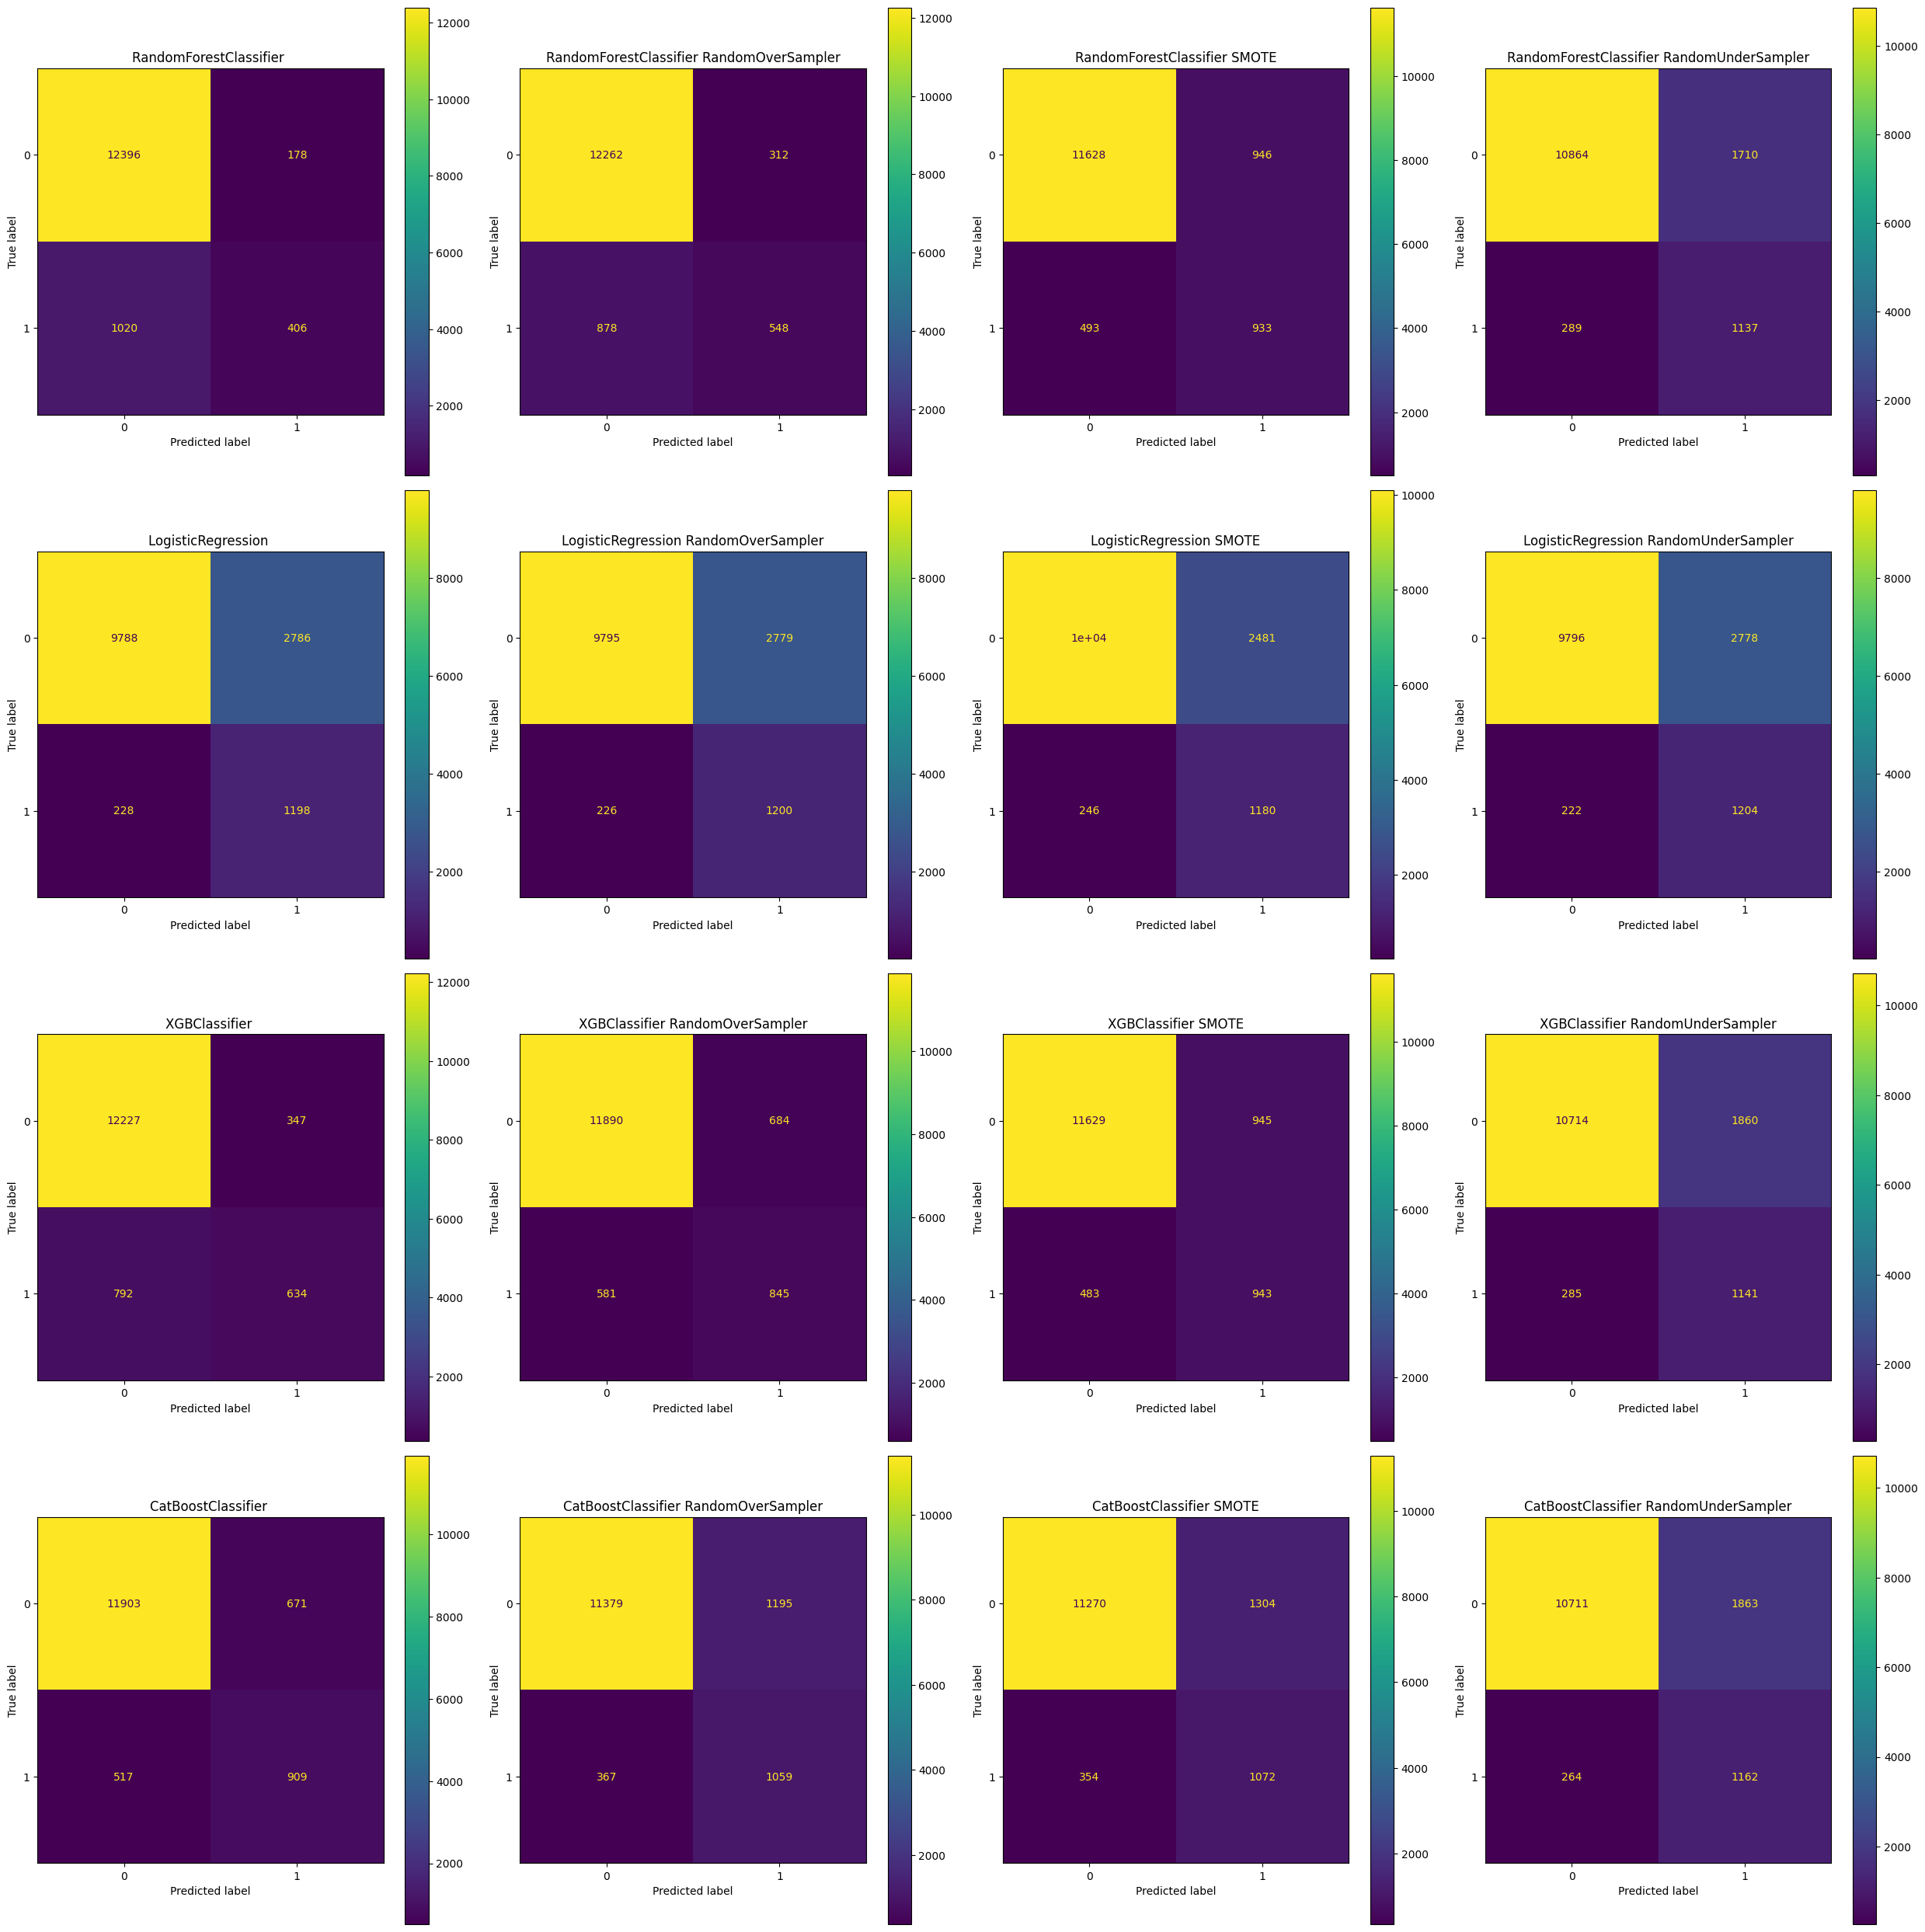

In [20]:
n_rows, n_cols= len(models), len(methods)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))


for model, params in model_params_pairs:
    
    new_params = {type(model).__name__.lower() +'__' + key: params[key] for key in params} # rename parameters so we can get them from pipeline
    
    for method in methods:
        
        save_file_name= 'rand_search_models/' + type(model).__name__ + '_' + str(method or '')[:-17] + '.joblib' #-17 to get rid od '(random_state=42)'
        
        if os.path.exists(save_file_name):

            clf = load(save_file_name)
            y_pred = clf.predict(X_test)

        else:
            # preprocessing data
            pipeline_pca_steps = [
                ('column_deletion', FunctionTransformer(delete_columns, kw_args={'columns_to_delete': columns_to_delete})),
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                (str(method), method),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=.9)),
                (type(model).__name__.lower(), model)
            ]
            pipeline_pca = Pipeline(pipeline_pca_steps)
            
            # tuning hyperparameters
            random_search = RandomizedSearchCV(pipeline_pca, param_distributions=new_params, cv=kf, n_jobs=10).fit(X_train, y_train)
            
            clf = random_search.best_estimator_
            
            # saving model
            os.makedirs('rand_search_models/', exist_ok=True)
            dump(clf, save_file_name)
            y_pred = random_search.predict(X_test)
        
        axes[models.index(model)][methods.index(method)].set_title(type(model).__name__ + ' ' + str(method or '')[:-17])
        ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=clf.classes_, 
                                                ax=axes[models.index(model)][methods.index(method)])
        
plt.tight_layout()

Visuals are helpful, but I would also like to examine the numbers.

In [21]:
score_table = pd.DataFrame(columns=['model', 'sampling method', 'f2', 'precision', 'recall', 'roc_auc', 'accuracy'])

for model in models:
    for method in methods:
        clf = load('rand_search_models/' + type(model).__name__ + '_' + str(method or '')[:-17] + '.joblib')
        y_pred = clf.predict(X_test)
        score_table_row = [type(model).__name__, str(method or '')[:-17], 
                            fbeta_score(y_test, y_pred, beta=2), precision_score(y_test, y_pred),recall_score(y_test, y_pred),
                            roc_auc_score(y_test, y_pred), accuracy_score(y_test, y_pred)]
        score_table.loc[len(score_table)] = score_table_row                

score_table

,model,sampling method,f2,precision,recall,roc_auc,accuracy
0,RandomForestClassifier,,0.322837,0.695205,0.284712,0.635278,0.914429
1,RandomForestClassifier,RandomOverSampler,0.417428,0.637209,0.384292,0.679739,0.915000
2,RandomForestClassifier,SMOTE,0.615192,0.496541,0.654278,0.789522,0.897214
3,RandomForestClassifier,RandomUnderSampler,0.664835,0.399368,0.797335,0.830670,0.857214
4,LogisticRegression,,0.618291,0.300703,0.840112,0.809272,0.784714
5,LogisticRegression,RandomOverSampler,0.619643,0.301583,0.841515,0.810252,0.785357
6,LogisticRegression,SMOTE,0.630005,0.322316,0.827489,0.815089,0.805214
7,LogisticRegression,RandomUnderSampler,0.621516,0.302361,0.844320,0.811694,0.785714
8,XGBClassifier,,0.474196,0.646279,0.444600,0.708502,0.918643
9,XGBClassifier,RandomOverSampler,0.584128,0.552649,0.592567,0.769084,0.909643


In [22]:
st_sorted = score_table.sort_values(by='f2', ascending=False)
st_sorted

,model,sampling method,f2,precision,recall,roc_auc,accuracy
15,CatBoostClassifier,RandomUnderSampler,0.665597,0.384132,0.814867,0.833352,0.848071
13,CatBoostClassifier,RandomOverSampler,0.665368,0.469831,0.742637,0.823800,0.888429
3,RandomForestClassifier,RandomUnderSampler,0.664835,0.399368,0.797335,0.830670,0.857214
14,CatBoostClassifier,SMOTE,0.663366,0.451178,0.751753,0.824024,0.881571
11,XGBClassifier,RandomUnderSampler,0.655370,0.380207,0.800140,0.826108,0.846786
6,LogisticRegression,SMOTE,0.630005,0.322316,0.827489,0.815089,0.805214
12,CatBoostClassifier,,0.623970,0.575316,0.637447,0.792042,0.915143
7,LogisticRegression,RandomUnderSampler,0.621516,0.302361,0.844320,0.811694,0.785714
10,XGBClassifier,SMOTE,0.621048,0.499470,0.661290,0.793068,0.898000
5,LogisticRegression,RandomOverSampler,0.619643,0.301583,0.841515,0.810252,0.785357


I'm not impressed with these models. Neither set of metrics is satisfactory, regardless of the model or sampling technique. Accuracy might be acceptable if we didn't have an imbalanced dataset with such poor recall and precision. Perhaps our handmade datasets will yield better results.

# Creating datasets<a id='datasets'></a>
[back to table of content](#toc)

As mentioned, we will calculate the sum and difference for AMT, MOU with roaming, and offnet/onnet MOU, as well as traffic in MB and traffic plans used in the months of interest. We will also create columns with information about dates of recharge, Facebook, and night pack usage. 

Notice that it is unnecessary to check whether there was a recharge in the 6th or 7th month, as we only need to determine if the customer was using services. However, it is crucial to know for the 8th month, since we aim to ascertain their continued interest in using services. Admittedly, we are unsure whether the user pays for used minutes/traffic or for future usage. However, it is commonly observed that payments are made for anticipated service use. Therefore, we will assume that the customer pays for upcoming services.

Since we will use combinations of same columns in all of our datasets, it is convenient to separate them right away:

- columns with recharge date will be transformed to boolean, since we only care if there was a recharge in 8th month at all;
- facebook and night pack columns will be transformed to bool too;
- offnet\onnet will be separate columns;
- schemas will be combined together;
- recharge amount for traffic and minutes will be combined;
- vol columns will represent combination of 3g and 2g traffic;
- we will also add unique column 'aon' that represents number of days a customer is using our operator.

In [23]:
def needed_features(df, features:list):
    
    features_schema = []
    features_amt = []
    features_mou = []
    features_roam = []
    features_vol = []
    features_onnet = []
    features_offnet = []
    
    for feature in features:
        
        if feature.startswith('total'):
            if 'mou' in feature:
                features_mou.append(feature)
            elif 'amt' in feature:
                features_amt.append(feature)
            
        if feature.startswith('roam'):
            features_roam.append(feature)

        if feature.startswith('onnet'):
            features_onnet.append(feature)

        if feature.startswith('offnet'):
            features_offnet.append(feature)
            
        if feature.startswith('vol'):
            features_vol.append(feature)
            
        if feature.startswith(('monthly', 'sachet')):
            features_schema.append(feature)
            
    return features_onnet, features_offnet, features_schema, features_amt, features_mou, features_roam, features_vol

In [24]:
features_onnet, features_offnet, features_schema, features_amt, features_mou, features_roam, features_vol = needed_features(df_orig, list(df_orig))

features_fb_night = ['fb_user_8', 'night_pck_user_8']


Combine all of our columns of interest into one dataset and fill in missing values with zeroes.

In [25]:
features_for_all_sets = features_fb_night+ features_amt + features_mou + features_roam + features_onnet + features_offnet + features_vol + features_schema 
features_for_all_sets.append('aon') #we add aon since it is unique feature that passed througs needed_features
X= df_orig[features_for_all_sets]
X.fillna(0, inplace=True)

/tmp/ipykernel_9756/1317579767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Save it just in case.

In [26]:
X.to_csv('df_orig_transformed.csv', index=False)

We aim to perform calculations on specific columns separately, so we will assign our features to groups. Although they are already divided, grouping them will help us organize datasets more effectively in the future.

In [27]:
feature_groups= [features_mou, features_roam, features_amt, features_vol, features_schema, features_onnet, features_offnet]
prefixes = ['mou', 'roam', 'amt', 'vol', 'schema', 'onnet', 'offnet']
zip_list_prefixes = list(zip(feature_groups, prefixes))

## Sum dataset<a id='datasets_sum'></a>
[back to table of content](#toc)

Here, we sum all columns of a group through month 6 to 8.

In [28]:
X_sum = X.copy(deep=True)

In [29]:
for feature_group, prefix in zip_list_prefixes:
        X_sum[prefix+'_sum'] = X_sum[feature_group].sum(axis=1)
        X_sum.drop(columns=feature_group, inplace=True)

In [30]:
X_sum

,fb_user_8,night_pck_user_8,aon,mou_sum,roam_sum,amt_sum,vol_sum,schema_sum,onnet_sum,offnet_sum
0,0.0,0.0,1958,411.96,0.00,152,0.00,0,174.25,131.25
1,0.0,0.0,710,130.31,0.00,195,356.87,1,0.00,56.88
2,0.0,0.0,882,350.61,0.00,190,0.00,0,16.46,136.04
3,0.0,0.0,982,454.98,1.63,530,0.00,0,23.27,197.47
4,1.0,0.0,647,181.17,69.37,548,913.16,20,32.24,104.73
...,...,...,...,...,...,...,...,...,...,...
69994,1.0,0.0,221,1380.81,14.96,959,388.90,8,18.29,870.10
69995,0.0,0.0,712,1068.32,0.00,821,0.00,0,545.63,193.87
69996,0.0,0.0,879,2424.66,0.00,1273,0.00,0,224.01,827.32
69997,1.0,0.0,277,136.22,29.64,776,3834.34,3,28.36,59.58


In [31]:
X_sum.to_csv('df_sum.csv', index=False)

## Diffference dataset<a id='datasets_diff'></a>
[back to table of content](#toc)

Same as before, but it is a difference between 8th and 6th month.

In [32]:
X_diff = X.copy(deep=True)

In [33]:
for feature_group, prefix in zip_list_prefixes:
        features_6 = [feature for feature in feature_group if feature.endswith('6')]
        features_8 = [feature for feature in feature_group if feature.endswith('8')]
    
        X_diff[prefix+'_diff'] = X_diff[features_8].sum(axis=1) - X_diff[features_6].sum(axis=1)
        X_diff.drop(columns=feature_group, inplace=True)

In [34]:
X_diff

,fb_user_8,night_pck_user_8,aon,mou_diff,roam_diff,amt_diff,vol_diff,schema_diff,onnet_diff,offnet_diff
0,0.0,0.0,1958,-48.86,0.00,-67,0.00,0,-47.29,-29.91
1,0.0,0.0,710,53.26,0.00,50,0.00,0,0.00,30.89
2,0.0,0.0,882,-144.14,0.00,-70,0.00,0,-0.53,-53.99
3,0.0,0.0,982,-33.46,1.63,-30,0.00,0,-7.26,-18.53
4,1.0,0.0,647,-40.73,-69.37,-168,-177.33,-1,-15.15,-47.36
...,...,...,...,...,...,...,...,...,...,...
69994,1.0,0.0,221,662.14,-14.96,462,144.31,1,10.93,381.64
69995,0.0,0.0,712,170.25,0.00,108,0.00,0,116.09,-1.47
69996,0.0,0.0,879,-198.03,0.00,-229,0.00,0,1.31,-71.70
69997,1.0,0.0,277,-21.57,-29.64,-234,-596.89,0,-7.30,-17.78


In [35]:
X_diff.to_csv('df_diff.csv', index=False)

## Last month dataset<a id='datasets_last'></a>
[back to table of content](#toc)

Same as sum dataset, but we only sum up columns of 8th month.

In [36]:
X_last = X.copy(deep=True)

In [37]:
for feature_group, prefix in zip_list_prefixes:
        features_8 = [feature for feature in feature_group if feature.endswith('8')]
    
        X_last[prefix+'_8'] = X_last[features_8].sum(axis=1)
        X_last.drop(columns=feature_group, inplace=True)

In [38]:
X_last

,fb_user_8,night_pck_user_8,aon,mou_8,roam_8,amt_8,vol_8,schema_8,onnet_8,offnet_8
0,0.0,0.0,1958,44.19,0.00,10,0.00,0,1.29,2.33
1,0.0,0.0,710,56.70,0.00,50,0.00,0,0.00,30.89
2,0.0,0.0,882,36.64,0.00,0,0.00,0,0.00,0.00
3,0.0,0.0,982,137.68,1.63,130,0.00,0,0.00,50.23
4,1.0,0.0,647,44.07,0.00,122,213.47,6,6.13,9.63
...,...,...,...,...,...,...,...,...,...,...
69994,1.0,0.0,221,662.14,0.00,512,144.31,1,10.93,381.64
69995,0.0,0.0,712,416.70,0.00,308,0.00,0,232.63,48.06
69996,0.0,0.0,879,756.83,0.00,397,0.00,0,78.44,263.84
69997,1.0,0.0,277,37.04,0.00,145,702.83,1,6.71,12.56


In [39]:
X_last.to_csv('df_last.csv', index=False)

# Modeling<a id='modeling'></a>
[back to table of content](#toc)

I will download all the datasets we created to ensure clarity and readability.

In [40]:
df_sum = pd.read_csv('df_sum.csv')
df_diff = pd.read_csv('df_diff.csv')
df_last = pd.read_csv('df_last.csv')
y = pd.read_csv('train.csv')['churn_probability']

Models we well use: 
1) Logistic Regression
2) Random Forest
3) XGBoost
4) Catboost

Sampling methods we will use:
1) Raw data as a baseline
2) Random oversampling
3) SMOTE
4) Random undersampling

## Split and scale data <a id='split_scale'></a>
[back to table of content](#toc)

In [41]:
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df


def split_and_scale_data(df, y):
    num_cols_to_scale = list(df.select_dtypes(include=np.number)) # Get numerical columns to scale
    df_train, df_test, y_train, y_test = train_test_split(df, y, stratify=y, test_size=0.2, random_state=42)
    
    df_train = Standard_Scaler(df_train, num_cols_to_scale)
    df_test = Standard_Scaler(df_test, num_cols_to_scale)

    return df_train, df_test, y_train, y_test

Below is a function that performs a random search across all combinations of our models and sampling methods for a given dataset. It also displays confusion matrices for each model, allowing us to compare them visually.

In [42]:
def compare_models(df, y, model_params_pairs: list, methods:list, save_suffix):
    
    # Split and scale data
    X_train, X_test, y_train, y_test = split_and_scale_data(df, y)

    # Define a grid to plot our confusion matrices on
    n_rows, n_cols= len(model_params_pairs), len(methods)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))

    # Main part that performs grid search on model
    for model, params in model_params_pairs:
        
        new_params = {type(model).__name__.lower() +'__' + key: params[key] for key in params} # rename parameters so pipeline could use them

        for method in methods:
    
            save_file_name= '3_datasets_models/' + type(model).__name__ + '_' + str(method or '')[:-17] + save_suffix + '.joblib' #-17 to get rid od '(random_state=42)'
            
            if os.path.exists(save_file_name):
    
                clf = load(save_file_name)
                y_pred = clf.predict(X_test)
    
            else:
            
                pipeline = make_pipeline(method, model)
               
                #search for best params
                random_search = RandomizedSearchCV(pipeline, param_distributions=new_params, cv=kf, scoring='roc_auc', n_jobs=10).fit(X_train, y_train)
                clf = random_search.best_estimator_
                
                os.makedirs('3_datasets_models/', exist_ok=True)
                dump(clf, save_file_name)
    
                #make prediction
                y_pred = clf.predict(X_test)

            #add plot of confusion matrix
            axes[models.index(model)][methods.index(method)].set_title(type(model).__name__ + ' ' + str(method or '')[:-17])
            ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=clf.classes_, ax=axes[models.index(model)][methods.index(method)])
    
    plt.tight_layout()


## Results <a id='results'></a>
[back to table of content](#toc)

Ignore those warnings, as they are benign.

/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the execu

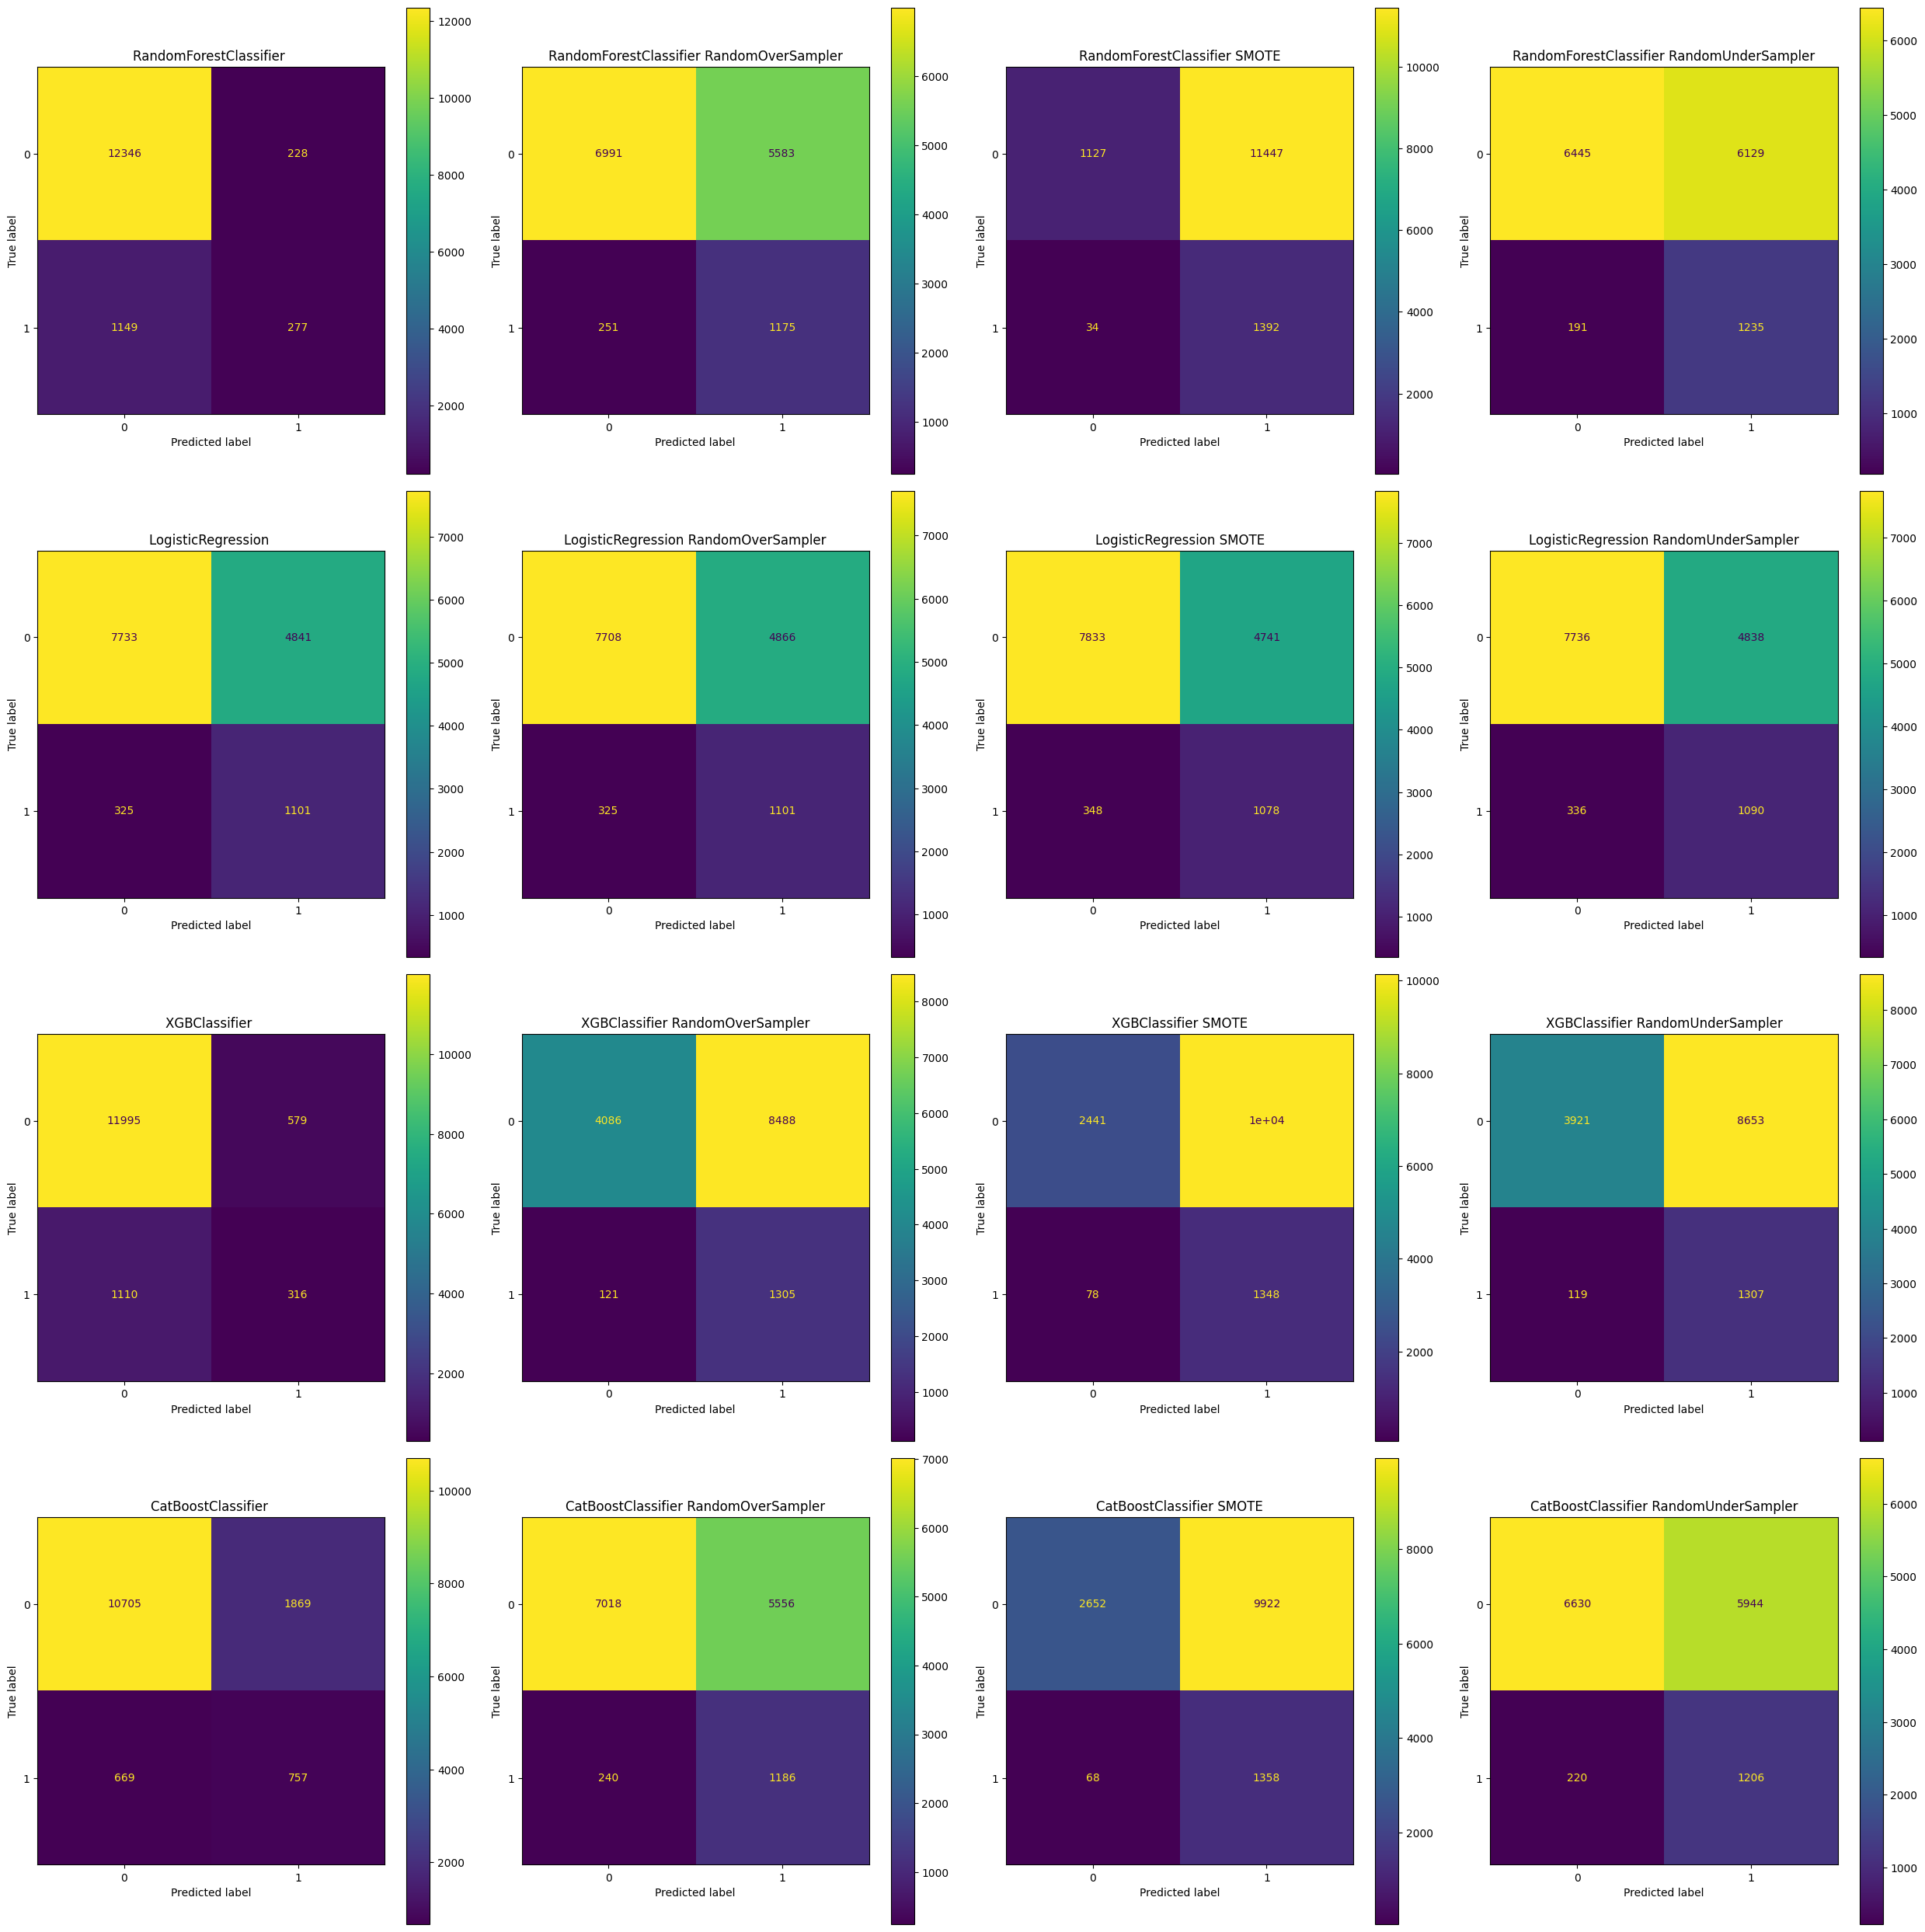

In [43]:
compare_models(df_sum, y, model_params_pairs, methods, '_sum')

/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


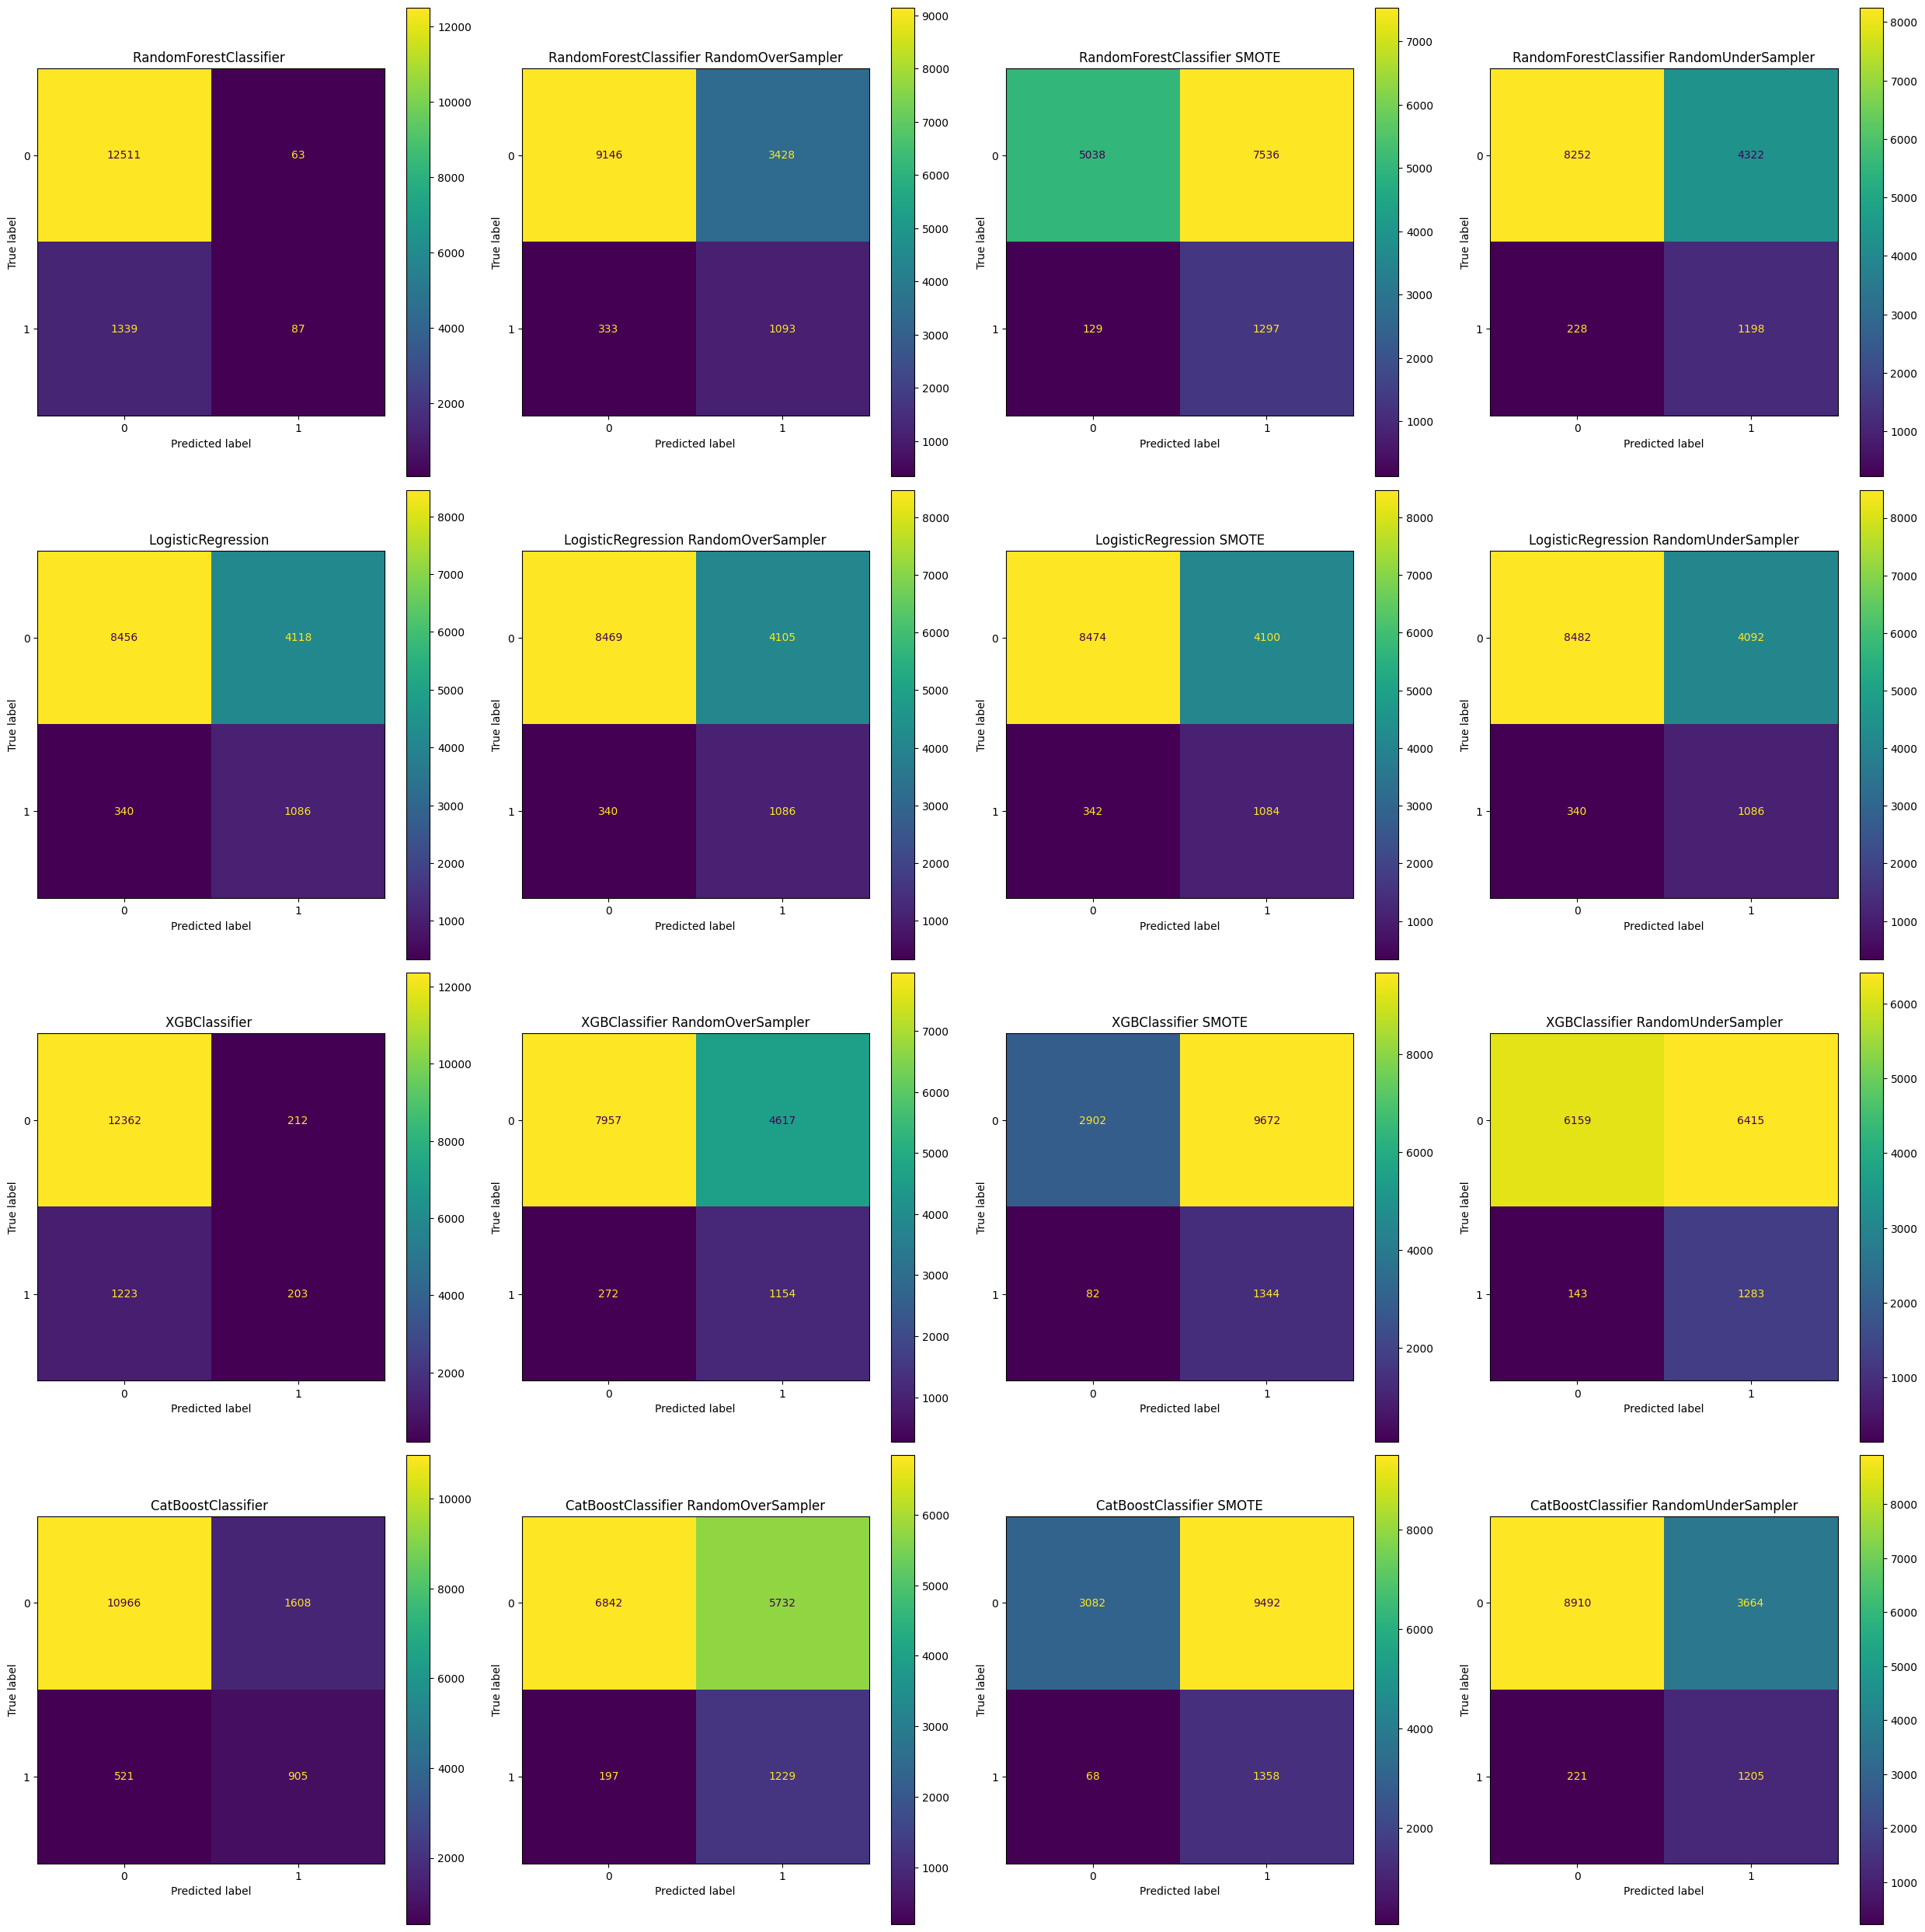

In [44]:
compare_models(df_diff, y, model_params_pairs, methods, '_diff')

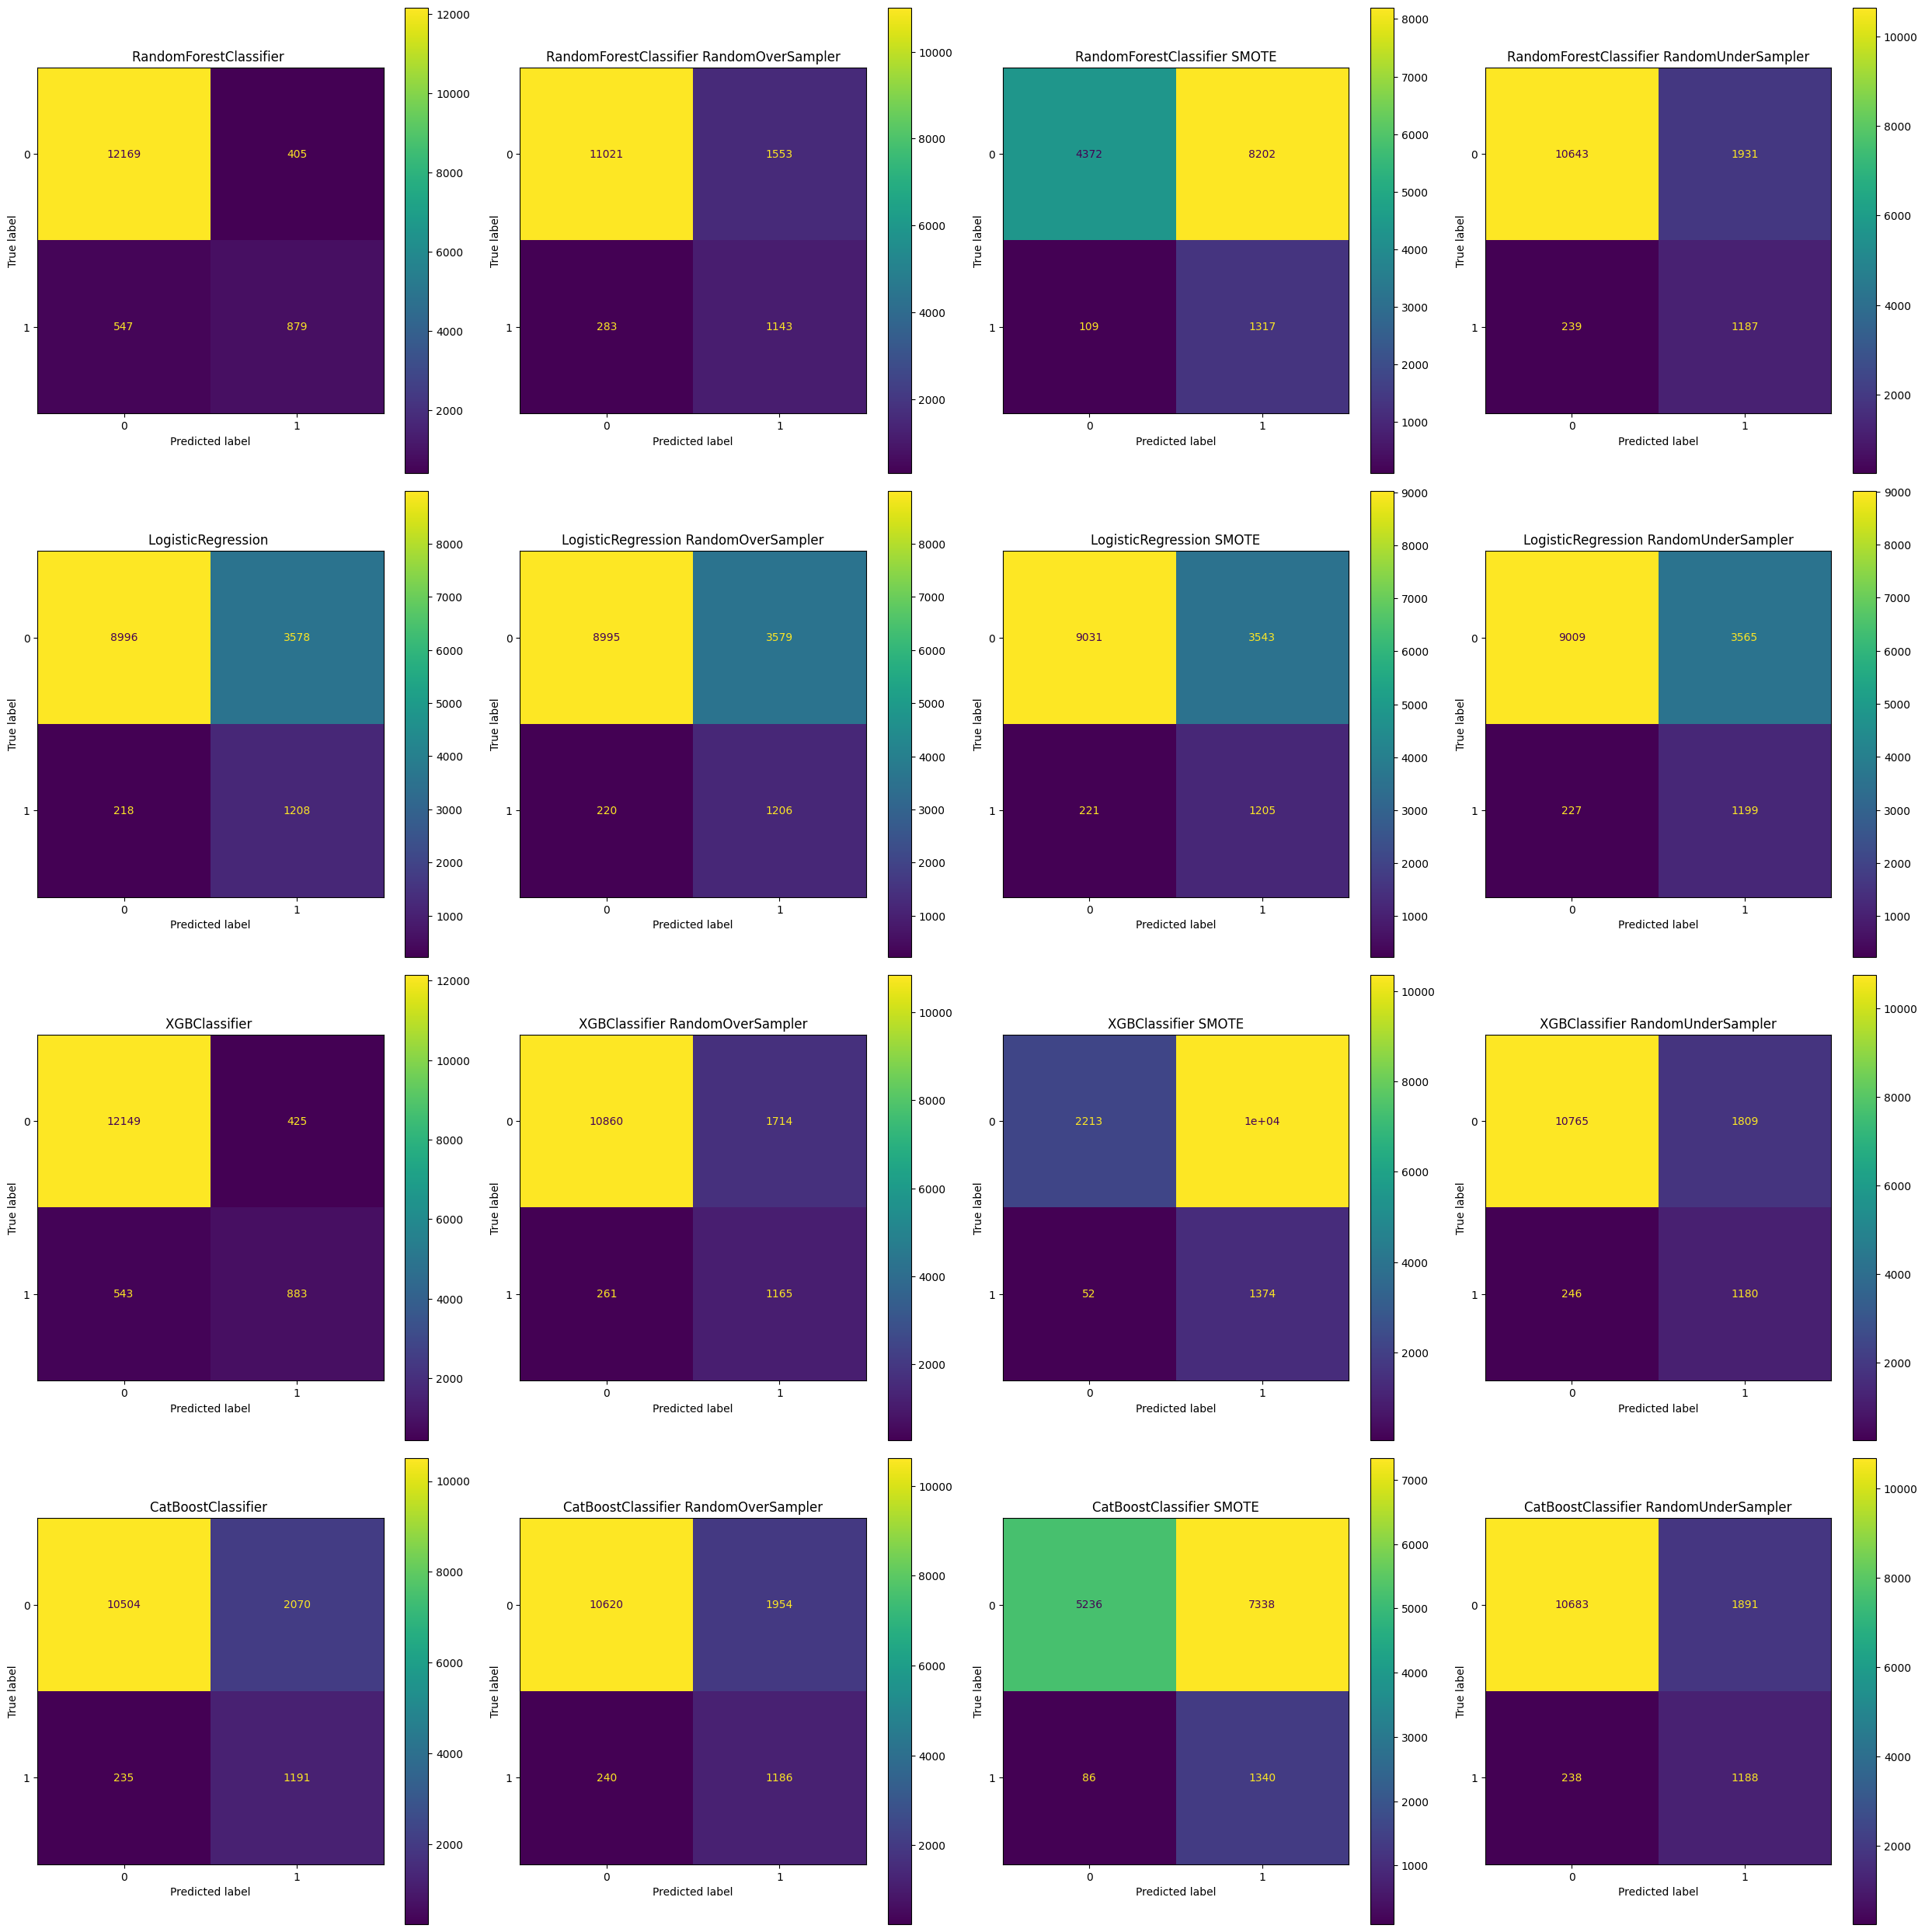

In [45]:
compare_models(df_last, y, model_params_pairs, methods, '_last')

Let's create a score table to organize the information.

There will be a lot to look at but don't be intimidated. I will explain everything in section below.

In [46]:
score_table = pd.DataFrame(columns=['dataset', 'model', 'sampling method', 'f2', 'precision', 'recall', 'roc_auc', 'accuracy'])

for suffix, df in (('_sum',df_sum),('_diff', df_diff), ('_last', df_last)):
    _, X_test, _, y_true = split_and_scale_data(df, y)
    for model in models:
        for method in methods:
            clf = load('3_datasets_models/' + type(model).__name__ + '_' + str(method or '')[:-17] + suffix + '.joblib')
            y_pred = clf.predict(X_test)
            score_table_row = [suffix[1:], type(model).__name__, str(method or '')[:-17], 
                               fbeta_score(y_true, y_pred, beta=2), precision_score(y_true, y_pred),recall_score(y_true, y_pred),
                               roc_auc_score(y_true, y_pred), accuracy_score(y_true, y_pred)]
            score_table.loc[len(score_table)] = score_table_row                

score_table

,dataset,model,sampling method,f2,precision,recall,roc_auc,accuracy
0,sum,RandomForestClassifier,,0.223063,0.548515,0.194250,0.588058,0.901643
1,sum,RandomForestClassifier,RandomOverSampler,0.471433,0.173868,0.823983,0.689986,0.583286
2,sum,RandomForestClassifier,SMOTE,0.375344,0.108420,0.976157,0.532893,0.179929
3,sum,RandomForestClassifier,RandomUnderSampler,0.472528,0.167708,0.866059,0.689312,0.548571
4,sum,LogisticRegression,,0.472694,0.185291,0.772090,0.693544,0.631000
5,sum,LogisticRegression,RandomOverSampler,0.471682,0.184515,0.772090,0.692550,0.629214
6,sum,LogisticRegression,SMOTE,0.467760,0.185255,0.755961,0.689456,0.636500
7,sum,LogisticRegression,RandomUnderSampler,0.468535,0.183873,0.764376,0.689807,0.630429
8,sum,XGBClassifier,,0.239430,0.353073,0.221599,0.587776,0.879357
9,sum,XGBClassifier,RandomOverSampler,0.421049,0.133258,0.915147,0.620052,0.385071


In [49]:
st_sorted = score_table.sort_values(by='accuracy', ascending=False)
st_sorted

,dataset,model,sampling method,f2,precision,recall,roc_auc,accuracy
32,last,RandomForestClassifier,,0.628935,0.684579,0.616410,0.792100,0.932000
40,last,XGBClassifier,,0.629635,0.675076,0.619215,0.792707,0.930857
0,sum,RandomForestClassifier,,0.223063,0.548515,0.194250,0.588058,0.901643
16,diff,RandomForestClassifier,,0.074308,0.580000,0.061010,0.528000,0.899857
24,diff,XGBClassifier,,0.165877,0.489157,0.142356,0.562748,0.897500
8,sum,XGBClassifier,,0.239430,0.353073,0.221599,0.587776,0.879357
33,last,RandomForestClassifier,RandomOverSampler,0.680357,0.423961,0.801543,0.839017,0.868857
41,last,XGBClassifier,RandomOverSampler,0.678667,0.404654,0.816971,0.840329,0.858929
43,last,XGBClassifier,RandomUnderSampler,0.678707,0.394781,0.827489,0.841811,0.853214
28,diff,CatBoostClassifier,,0.550688,0.360127,0.634642,0.753380,0.847929


# Conclusion <a id='conclusion'></a>
[back to table of content](#toc)

We've been working with imbalanced dataset and implemented most popular sampling techniques to get better results. But have we got better models now?

- There are some good accuracy scores; however, the corresponding precision and recall scores indicate that the model poorly distinguished between the positive and negative classes, assigning the vast majority of instances to one of them. We will examine some exceptions later.
- For recall, datasets with oversampling techniques generally perform better; however, if overall accuracy is poor, it may not be worthwhile to treat half of the clients as if they have a higher churn probability.
- For precision, XGBoost and RandomForest dominated the chart from both ends on our handmade datasets, showing worst and best results. Last month and difference datasets without implemented sampling techniques yielded the best results, while random oversampling and SMOTE appeared to be the worst cases with those models.
- The dataset from last month yielded good ROC-AUC scores using CatBoost and XGBoost, although the precision was relatively low.
- If we want to choose a model that balances precision and recall, we should consider the F-score. The XGBoost and RandomForest on last month and difference datasets yield an F-score of approximately 0.62, which is not particularly high. However, the accuracy and ROC_AUC for those models and datasets combinations are acceptable, indicating that we have not incorrectly labeled many loyal customers as churned and vice versa. Additionally, we improved overall accuracy by 3% compared to the method of assigning all customers to the negative class.

Our custom datasets, which incorporate last month's significance and the importance of trends, appear to outperform a basic PCA transformation that retains 90% of the initial variance. When combined with XGBoost and RandomForest algorithms, this approach yielded satisfactory results. However, it is crucial to identify which features were most significant. The business should consider this information in its strategic decision-making process.

In [48]:
pipe = load('3_datasets_models/XGBClassifier__last.joblib')
model = pipe.named_steps['xgbclassifier']
feature_importances = model.feature_importances_
importances = pd.DataFrame({'feature': df_last.columns, 'importance': feature_importances})
importances = importances.sort_values('importance', ascending=False)
print(importances)

            feature  importance
3             mou_8    0.471021
0         fb_user_8    0.304541
6             vol_8    0.080785
4            roam_8    0.067207
2               aon    0.019351
5             amt_8    0.015584
9          offnet_8    0.012245
8           onnet_8    0.010896
7          schema_8    0.010478
1  night_pck_user_8    0.007892


The use of night pack schemes is important for churn prediction; however, businesses should also focus on customers who frequently use roaming and offer them more favorable terms for roaming plans.